Lade Gewichte aus: best_small_cifar10_cnn.pt
Test Accuracy: 0.8230 (8230/10000)
Absolute Confusion Matrix gespeichert unter: confusion_matrix_cifar10_absolute.png


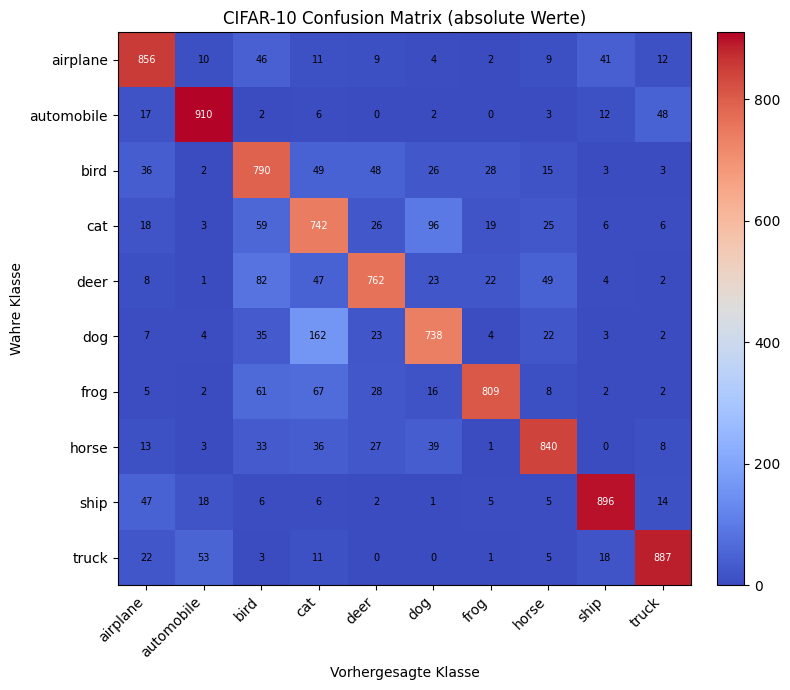

Confusion Matrix gespeichert unter: confusion_matrix_cifar10.png


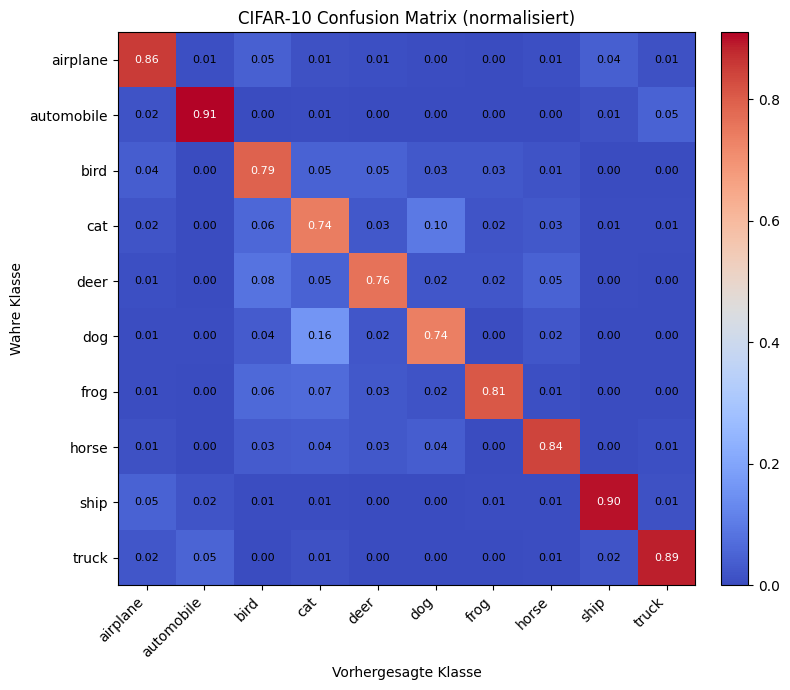

In [4]:
# eval_cifar10_confusion.py
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ---------------------
# Einstellungen
# ---------------------
CANDIDATE_WEIGHT_PATHS = [
    "best_small_cifar10_cnn.pt",   # bevorzugt: "bestes Modell"
    "small_cifar10_cnn.pt",        # Fallback: letzter Checkpoint
]
BATCH_SIZE = 256
NUM_WORKERS = 1
DATA_ROOT = "./data"

# Gerät wählen (für Inferenz gern automatisch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# ---------------------
# Modell-Definition (muss exakt zum Trainingsmodell passen)
# ---------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32x32 -> 32x32
        self.pool  = nn.MaxPool2d(2, 2)               # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 16x16 -> 16x16
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)# 16x16 -> 16x16
        self.head  = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),                  # -> 128x1x1
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.head(x)
        return x

# ---------------------
# Test-Daten
# ---------------------
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616)),
])

test_ds  = datasets.CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform_test)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=torch.cuda.is_available())

# ---------------------
# Gewichte laden
# ---------------------
def find_weights(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    raise FileNotFoundError(
        f"Keine Gewichtsdatei gefunden. Angefragt: {paths}. "
        "Bitte Dateinamen oben in CANDIDATE_WEIGHT_PATHS anpassen."
    )

weights_path = find_weights(CANDIDATE_WEIGHT_PATHS)
print(f"Lade Gewichte aus: {weights_path}")

model = SmallCNN().to(device)
state = torch.load(weights_path, map_location=device)
# erlaubt sowohl reines state_dict als auch { 'state_dict': ... }
state_dict = state["state_dict"] if isinstance(state, dict) and "state_dict" in state else state
model.load_state_dict(state_dict)
model.eval()

# ---------------------
# Auswertung & Confusion Matrix
# ---------------------
num_classes = 10
conf_mat = torch.zeros((num_classes, num_classes), dtype=torch.long)
correct, total = 0, 0

all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(dim=1)

        # Accuracy
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Confusion Matrix aufsummieren
        for t, p in zip(labels.view(-1), preds.view(-1)):
            conf_mat[t.long(), p.long()] += 1

        # Für evtl. weitere Auswertungen
        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f} ({correct}/{total})")

# Normalisierte Confusion Matrix (zeilenweise)
conf_mat_np = conf_mat.cpu().numpy()
row_sums = conf_mat_np.sum(axis=1, keepdims=True).clip(min=1)
conf_mat_norm = conf_mat_np / row_sums

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


# Rohmatrix (absolute Werte)
fig_raw, ax_raw = plt.subplots(figsize=(8, 7))
im_raw = ax_raw.imshow(conf_mat_np, interpolation='nearest', aspect='auto', cmap="coolwarm")
ax_raw.set_title("CIFAR-10 Confusion Matrix (absolute Werte)")
fig_raw.colorbar(im_raw, ax=ax_raw, fraction=0.046, pad=0.04)
ax_raw.set_xticks(np.arange(num_classes))
ax_raw.set_yticks(np.arange(num_classes))
ax_raw.set_xticklabels(classes, rotation=45, ha="right")
ax_raw.set_yticklabels(classes)
ax_raw.set_xlabel("Vorhergesagte Klasse")
ax_raw.set_ylabel("Wahre Klasse")

# Werte in die Zellen schreiben (für Übersichtlichkeit):
thresh_raw = conf_mat_np.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        val = conf_mat_np[i, j]
        ax_raw.text(j, i, str(val),
                    ha="center", va="center",
                    color="white" if val > thresh_raw else "black", fontsize=7)

plt.tight_layout()
plt.savefig("confusion_matrix_cifar10_absolute.png", dpi=200)
print("Absolute Confusion Matrix gespeichert unter: confusion_matrix_cifar10_absolute.png")
plt.show()


# ---------------------
# Normalisierte Confusion Matrix
# ---------------------
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(conf_mat_norm, interpolation='nearest', aspect='auto', cmap="coolwarm")
ax.set_title("CIFAR-10 Confusion Matrix (normalisiert)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
ax.set_xlabel("Vorhergesagte Klasse")
ax.set_ylabel("Wahre Klasse")

# Werte eintragen (optional, bei kleineren Matrices gut lesbar)
thresh = conf_mat_norm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        val = conf_mat_norm[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha="center", va="center",
                color="white" if val > thresh else "black", fontsize=8)

plt.tight_layout()
# als Datei speichern UND anzeigen
out_path = "confusion_matrix_cifar10.png"
plt.savefig(out_path, dpi=200)
print(f"Confusion Matrix gespeichert unter: {out_path}")
plt.show()


In [7]:
test_ds  = datasets.CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform_test)
test_loader  = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [8]:
len(test_loader)

1

In [9]:
for imgs, labels in test_loader:
    print(imgs.shape)
    print(labels.shape)

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


In [10]:
labels

tensor([3, 8, 8,  ..., 5, 1, 7])

In [13]:
for class_id in range (10):
    print((labels == class_id).sum())

tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)
tensor(1000)


In [14]:
import pandas
s = pandas.Series( labels )
s

0       3
1       8
2       8
3       0
4       6
       ..
9995    8
9996    3
9997    5
9998    1
9999    7
Length: 10000, dtype: int64

In [15]:
s.value_counts()

3    1000
8    1000
0    1000
6    1000
1    1000
9    1000
5    1000
7    1000
4    1000
2    1000
Name: count, dtype: int64

In [16]:
type(row_sums)

numpy.ndarray

In [17]:
row_sums.shape

(10, 1)

In [ ]:
row_sums

array([[1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000],
       [1000]])

In [26]:
row_sums[class_id][0]

1000

In [39]:
summe = 0.0
N = 0
for class_id in range(10):
 
    class_acc = conf_mat_norm[class_id, class_id]
    nr_imgs_per_class = row_sums[class_id][0]
    summe += class_acc * nr_imgs_per_class
    N += nr_imgs_per_class

    class_name = test_ds.classes[class_id]
    print(f"Genauigkeit für Klasse #{class_id:3} / {class_name:<15} : {class_acc}")

print("-"*10)
print("Durchschnittliche Klassifikationsgenauigkeit (ACC):", summe / N)

Genauigkeit für Klasse #  0 / airplane        : 0.856
Genauigkeit für Klasse #  1 / automobile      : 0.91
Genauigkeit für Klasse #  2 / bird            : 0.79
Genauigkeit für Klasse #  3 / cat             : 0.742
Genauigkeit für Klasse #  4 / deer            : 0.762
Genauigkeit für Klasse #  5 / dog             : 0.738
Genauigkeit für Klasse #  6 / frog            : 0.809
Genauigkeit für Klasse #  7 / horse           : 0.84
Genauigkeit für Klasse #  8 / ship            : 0.896
Genauigkeit für Klasse #  9 / truck           : 0.887
----------
Durchschnittliche Klassifikationsgenauigkeit (ACC): 0.823


In [34]:
test_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [40]:
model

SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)